## **Objective**

To build a sentiment-driven analytics engine that predicts short-term stock price movements by analyzing financial news headlines using FinBERT, and correlating them with next-day returns from historical price data.


## **Technologies & Models Used**

- **Data Sources**:
  - [Yahoo Finance](https://finance.yahoo.com) for historical stock prices (e.g., SPY ETF)
  - [Hugging Face Datasets](https://huggingface.co/datasets/Zihan1004/FNSPID) for financial news headlines
- **Libraries**:
  - `pandas`, `yfinance`, `altair`, `scikit-learn`, `matplotlib`, `seaborn`, `streamlit`
- **NLP Model**:
  - [FinBERT](https://huggingface.co/yiyanghkust/finbert-tone) — fine-tuned BERT model for financial sentiment classification
- **ML Model**:
  - Logistic Regression to predict price movement signals based on sentiment polarity

---

## **Project Workflow**

1. Download daily price data for SPY using `yfinance`
2. Stream 10K+ financial headlines using Hugging Face’s `datasets`
3. Clean and align news and price data by ticker and timestamp
4. Calculate 1-day forward returns and label them as **Bullish**, **Bearish**, or **Neutral**
5. Apply **FinBERT** to classify sentiment of each headline
6. Merge sentiment and return labels into a unified dataset
7. Train a model to predict future movement using sentiment
8. Simulate and backtest a simple trading strategy:
   - Buy if sentiment is positive
   - Short if sentiment is negative
9. Deploy an interactive **Streamlit dashboard** to explore results by stock and time

---

## **Expected Output**

- A labeled dataset with headline, FinBERT sentiment, next-day return, and signal
- A trained ML model that classifies short-term return direction
- 📊 A backtested trading strategy with cumulative return visualization
- 🌐 A fully deployed dashboard for visualizing sentiment vs. price trends<br>


Let's move towards the implementation part

### **Step 1: Fetch SPY Historical Price Data**
Use `yfinance` to download historical OHLC data for the SPY ETF (S&P 500 Index tracker).


In [1]:
# 📘 Step 1: Install yfinance
!pip install yfinance --quiet

# 📘 Step 2: Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 📘 Step 3: Define your ticker (SPY = S&P 500 ETF)
ticker = "SPY"

# Fetch 2 years of daily data
spy_df = yf.download(ticker, start="2022-01-01", end="2024-12-31", progress=False)

# Reset index to make 'Date' a column
spy_df.reset_index(inplace=True)
spy_df = spy_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Preview the data
spy_df.head()

YF.download() has changed argument auto_adjust default to True


Price,Date,Open,High,Low,Close,Volume
Ticker,,SPY,SPY,SPY,SPY,SPY
0,2022-01-03,454.465060,455.944021,452.127392,455.810425,72668200
1,2022-01-04,457.251201,457.976369,453.778055,455.657745,71178700
2,2022-01-05,455.285672,456.068088,446.812751,446.908173,104538900
3,2022-01-06,446.440585,449.236258,444.093338,446.488281,86858900
4,2022-01-07,446.497862,447.690558,443.349125,444.723114,85111600


### **Step 2: Visualize SPY Closing Price**  
Create a time-series line plot to understand SPY price movements over time.

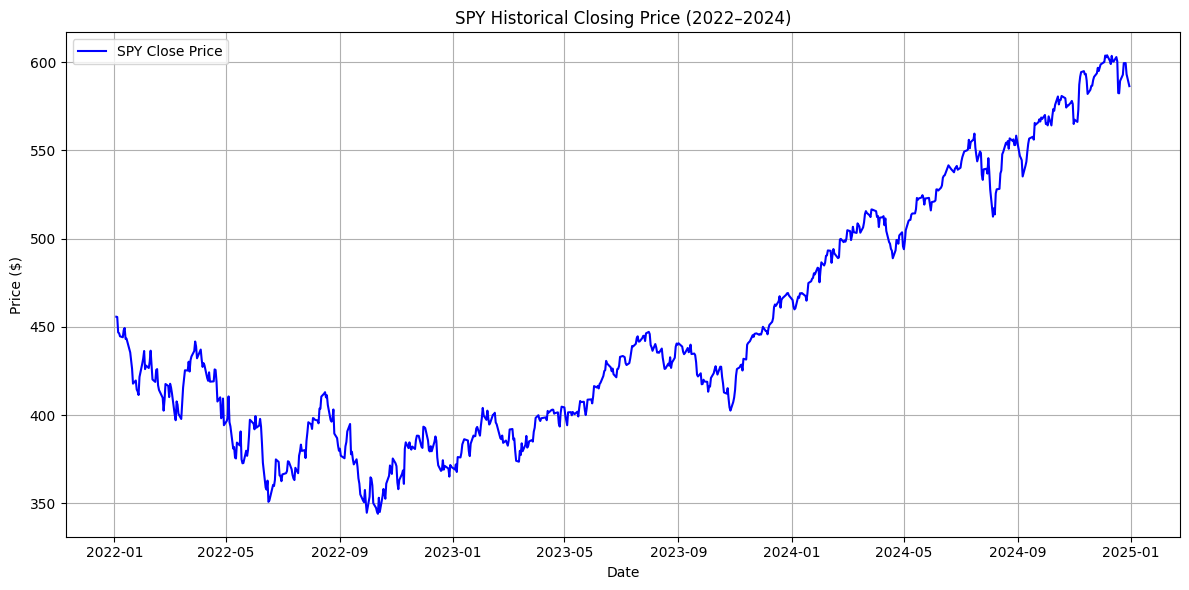

In [2]:
# Line plot of SPY close price over time
plt.figure(figsize=(12, 6))
plt.plot(spy_df['Date'], spy_df['Close'], label='SPY Close Price', color='blue')
plt.title("SPY Historical Closing Price (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### **Step 3: Save SPY Price Data to CSV**  
Export the cleaned SPY data to a CSV file for future use.

In [3]:
# Save as CSV
spy_df.to_csv('spy_historical_prices.csv', index=False)
print("✅ SPY price data saved to spy_historical_prices.csv")

✅ SPY price data saved to spy_historical_prices.csv


### **Step 4: Install Hugging Face `datasets`**  
Install the `datasets` library to stream large datasets from Hugging Face.


In [4]:
pip install datasets --upgrade

In [5]:
from huggingface_hub import login

## Load the dataset in Python

In [ ]:
from google.colab import files

# Upload the zip file manually
uploaded = files.upload()

Saving full_history.zip to full_history.zip


In [ ]:
import zipfile

with zipfile.ZipFile("full_history.zip", 'r') as zip_ref:
    zip_ref.extractall("full_history")

print("✅ Extracted full_history folder.")


✅ Extracted full_history folder.


In [33]:
# For test
import os

for root, dirs, files in os.walk("full_history"):
    for name in files:
        print(os.path.join(root, name))

if not any(os.walk("full_history")):
    print("❌ No files found inside full_history.")


full_history/full_history/PHGE.csv
full_history/full_history/JDIV.csv
full_history/full_history/ADI.csv
full_history/full_history/MMI.csv
full_history/full_history/BSVN.csv
full_history/full_history/CORR.csv
full_history/full_history/HFRO.csv
full_history/full_history/NKE.csv
full_history/full_history/FEI.csv
full_history/full_history/EVSTC.csv
full_history/full_history/ORA.csv
full_history/full_history/RMBL.csv
full_history/full_history/CGC.csv
full_history/full_history/CDZI.csv
full_history/full_history/CUK.csv
full_history/full_history/CUBE.csv
full_history/full_history/ISSC.csv
full_history/full_history/NIU.csv
full_history/full_history/MMM.csv
full_history/full_history/ASHX.csv
full_history/full_history/KOMP.csv
full_history/full_history/SLVP.csv
full_history/full_history/SPTI.csv
full_history/full_history/TRQ.csv
full_history/full_history/SPI.csv
full_history/full_history/RDS-A.csv
full_history/full_history/MDU.csv
full_history/full_history/GHL.csv
full_history/full_history/ALV.c

In [32]:
import os
import pandas as pd

# Path to folder that contains all the price CSVs
price_folder = "full_history/full_history"

# Collect and combine all price data
price_frames = []
for file in os.listdir(price_folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(price_folder, file))
        ticker = file.replace(".csv", "")
        df['Stock_symbol'] = ticker  # Add a ticker column
        price_frames.append(df)

# Concatenate into a single price DataFrame
price_df = pd.concat(price_frames, ignore_index=True)
price_df['date'] = pd.to_datetime(price_df['date'])

# Preview the result
print("✅ Loaded data from", len(price_frames), "stocks")
price_df.head()


✅ Loaded data from 7693 stocks


,date,volume,open,high,low,close,adj close,Stock_symbol
0,2023-12-28,449200.0,0.304,0.305,0.284,0.290,0.290,PHGE
1,2023-12-27,2139100.0,0.274,0.380,0.274,0.310,0.310,PHGE
2,2023-12-26,111700.0,0.270,0.320,0.270,0.292,0.292,PHGE
3,2023-12-22,41400.0,0.300,0.307,0.285,0.290,0.290,PHGE
4,2023-12-21,389100.0,0.260,0.318,0.260,0.300,0.300,PHGE


##Load the News Headlines Dataset

In [8]:
!pip install datasets --quiet

from datasets import load_dataset

# Load the dataset in streaming mode
dataset = load_dataset("Zihan1004/FNSPID", split="train", streaming=True)

# Preview first few rows
for i, row in enumerate(dataset):
    print(row['Date'], "|", row['Stock_symbol'], "|", row['Article_title'])
    if i == 9:
        break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


2020-06-05 06:30:54 UTC | A | Stocks That Hit 52-Week Highs On Friday
2020-06-03 06:45:20 UTC | A | Stocks That Hit 52-Week Highs On Wednesday
2020-05-26 00:30:07 UTC | A | 71 Biggest Movers From Friday
2020-05-22 08:45:06 UTC | A | 46 Stocks Moving In Friday's Mid-Day Session
2020-05-22 07:38:59 UTC | A | B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88
2020-05-22 07:23:25 UTC | A | CFRA Maintains Hold on Agilent Technologies, Lowers Price Target to $85
2020-05-22 05:36:20 UTC | A | UBS Maintains Neutral on Agilent Technologies, Raises Price Target to $87
2020-05-22 05:07:04 UTC | A | Agilent Technologies shares are trading higher after the company reported better-than-expected Q2 EPS and sales results.
2020-05-22 04:37:59 UTC | A | Wells Fargo Maintains Overweight on Agilent Technologies, Raises Price Target to $95
2020-05-22 04:06:17 UTC | A | 10 Biggest Price Target Changes For Friday


**Collect Sample Data (~10K rows)
We’ll collect a sample of the streamed dataset into a DataFrame for processing and sentiment scoring.**

In [9]:
import pandas as pd

# Collect first 10,000 rows into a DataFrame
rows = []
for i, row in enumerate(dataset):
    rows.append(row)
    if i == 9999:
        break

news_df = pd.DataFrame(rows)

# Fix column names and types
news_df.rename(columns={"Date": "date"}, inplace=True)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# 🔧 Strip timezone info to match price_df
news_df['date'] = news_df['date'].dt.tz_localize(None)

# Drop rows with missing headlines
news_df.dropna(subset=['Article_title'], inplace=True)

# Preview
news_df[['date', 'Stock_symbol', 'Article_title']].head()


,date,Stock_symbol,Article_title
0,2020-06-05 06:30:54,A,Stocks That Hit 52-Week Highs On Friday
1,2020-06-03 06:45:20,A,Stocks That Hit 52-Week Highs On Wednesday
2,2020-05-26 00:30:07,A,71 Biggest Movers From Friday
3,2020-05-22 08:45:06,A,46 Stocks Moving In Friday's Mid-Day Session
4,2020-05-22 07:38:59,A,B of A Securities Maintains Neutral on Agilent...


**Merge with Your price_df
Assuming you already loaded and combined your stock price files into a DataFrame named price_df:**

In [10]:
import pandas as pd  # ✅ Add this line

# Ensure price_df exists and has proper date format
price_df['date'] = pd.to_datetime(price_df['date'])

# Merge on date and ticker
merged_df = pd.merge(news_df, price_df, on=['date', 'Stock_symbol'], how='inner')

# Sort for calculating return
merged_df.sort_values(by=['Stock_symbol', 'date'], inplace=True)

# Preview
merged_df[['date', 'Stock_symbol', 'Article_title', 'close']].head()


,date,Stock_symbol,Article_title,close
1362,2009-04-29,A,Going Against the Herd,12.896996
1361,2009-06-01,A,super-trades - Two 52 week highs and others ab...,13.505007
1360,2009-07-14,A,Skystar Bio-Pharmaceutical Announces Expansion...,13.941345
1359,2009-07-30,A,The Gold/Silver Ratio From 1300 to 1900...And Now,16.566525
1358,2009-08-04,A,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",17.288984


**Compute 1-Day Forward Return
This helps you label whether the stock moved bullishly, bearishly, or neutrally the day after the headline.**

In [11]:
# Compute the next day's close price
merged_df['next_close'] = merged_df.groupby('Stock_symbol')['close'].shift(-1)

# Calculate the 1-day return in percentage
merged_df['return_1d'] = ((merged_df['next_close'] - merged_df['close']) / merged_df['close']) * 100

# ✅ Preview with Article Title
merged_df[['date', 'Stock_symbol', 'Article_title', 'close', 'next_close', 'return_1d']].head()


,date,Stock_symbol,Article_title,close,next_close,return_1d
1362,2009-04-29,A,Going Against the Herd,12.896996,13.505007,4.714363
1361,2009-06-01,A,super-trades - Two 52 week highs and others ab...,13.505007,13.941345,3.230938
1360,2009-07-14,A,Skystar Bio-Pharmaceutical Announces Expansion...,13.941345,16.566525,18.830172
1359,2009-07-30,A,The Gold/Silver Ratio From 1300 to 1900...And Now,16.566525,17.288984,4.360962
1358,2009-08-04,A,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",17.288984,16.645208,-3.723619


**Label Bullish/Bearish/Neutral Signal
Now convert those returns into class labels for modeling:**

In [12]:
# Define signal labeling logic
def label_signal(ret):
    if ret > 0.5:
        return 'Bullish'
    elif ret < -0.5:
        return 'Bearish'
    else:
        return 'Neutral'

# Apply signal labels
merged_df['signal'] = merged_df['return_1d'].apply(label_signal)

# Preview labeled data with signals
merged_df[['date', 'Stock_symbol', 'Article_title', 'return_1d', 'signal']].head()

,date,Stock_symbol,Article_title,return_1d,signal
1362,2009-04-29,A,Going Against the Herd,4.714363,Bullish
1361,2009-06-01,A,super-trades - Two 52 week highs and others ab...,3.230938,Bullish
1360,2009-07-14,A,Skystar Bio-Pharmaceutical Announces Expansion...,18.830172,Bullish
1359,2009-07-30,A,The Gold/Silver Ratio From 1300 to 1900...And Now,4.360962,Bullish
1358,2009-08-04,A,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",-3.723619,Bearish


**Run FinBERT Sentiment Scoring**

In [13]:
!pip install transformers --quiet

**Load FinBERT Model from Hugging Face**

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment analysis pipeline
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

**Apply FinBERT to Headlines
Start with a sample of 500–1000 headlines for speed. Once it's working, you can scale.**

In [15]:
# Use a sample for quick testing (optional)
sample_df = merged_df.sample(1000, random_state=42).copy()

# Run FinBERT sentiment analysis
sample_df['sentiment'] = sample_df['Article_title'].apply(lambda x: finbert(x)[0]['label'])

# Preview
sample_df[['Article_title', 'sentiment', 'signal']].head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,Article_title,sentiment,signal
5733,"Earnings Scheduled For August 15, 2017",Neutral,Bullish
3486,Base Metals Rise as China Rates Stay Put,Positive,Bearish
3570,Alcoa Reports Better Than Expected Earnings,Positive,Neutral
6827,Mid-Afternoon Market Update: U.S. Stocks Turn ...,Positive,Neutral
625,Stifel Nicolaus Maintains Agilent Technologies...,Positive,Neutral


In [25]:
sample_df.to_csv("sample_df.csv", index=False)

In [18]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00
